# Week 7: Exploring the Parameter Space of Gradient Boosting

In this video and notebook we'll explore how to experiment with different model parameters to improve performance and understand trade-offs:

- How to systematically tune hyperparameters like `learning_rate`, `n_estimators`, and `max_depth`.
- How to use repeated cross-validation to evaluate model performance.
- How to prevent overfitting by visualizing training vs. validation MSE vs Test MSEs. We'll also look at the standard deviation of the CV scores for insight. 
- Using Randomized Grid Search as an alternative strategy.

### Workflow Summary
1. Load and Prepare Data  
   We’ll be using the California Housing Dataset, which is already split into training and testing sets.

2. Define and Tune Parameters  
   We have a default set of parameters in a dictionary (`Parameters_Default`), ranked by their importance for tuning.

3. Run Gradient Boosting with Cross-Validation  
   We’ll track Mean Squared Error (MSE) across multiple cross-validation folds to evaluate different settings.

4. Iteratively Sweep Parameters and Visualize Results  
   Using `sweep_parameter()`, we will:
   - Test a range of values for a given parameter.
   - Plot training vs. validation vs test MSE to diagnose overfitting or underfitting.
   - Plot the standard deviation of the CV scores.
   - Select the best parameter value for our model, based on analyzing the results. 
   - Store the best values in a dictionary `Parameters` to store the best results over all experiments. 

5. Using Early Stopping to stop training when no improvement to the CV score is detected.

6. Using `RandomizeGridCV` to explore the parameter space   
   As an alternative to the iterative approach, we'll then try to do the same thing using `RandomizedSearchCV`


In [1]:
# Useful imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import sys
import os
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV,RepeatedKFold,RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

from scipy.stats import uniform, randint

# Globals
random_state = 42

# Utility function to format execution time
def format_time(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    remaining_seconds = seconds % 60
    if hours == 0 and minutes == 0:
        return f"{seconds:.2f}s"
    elif hours == 0:
        return f"{minutes}m {remaining_seconds:.2f}s"
    return f"{hours}h {minutes}m {remaining_seconds:.2f}s"

In [2]:
# Load the California Housing Dataset
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Split dataset into training and testing sets
# These are GLOBAL VARIABLES
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Parameters

In [3]:
# Most important default parameters stored in a dictionary, approximately in order of usefulness for most situations. 

Parameters_default = {
    'learning_rate'           : 0.1,             # Shrinks the contribution of each tree. Affects the speed of learning and overfitting.
    'n_estimators'            : 100,             # The number of boosting stages to be run. More estimators can improve performance but increase training time.
    'max_depth'               : 3,               # Maximum depth of individual trees. Controls model complexity.
    'min_samples_split'       : 2,               # Minimum number of samples required to split an internal node. Affects model flexibility.
    'min_samples_leaf'        : 1,               # Minimum number of samples required to be at a leaf node. Helps prevent overfitting.
    'max_features'            : None,            # Number of features to consider when looking for best split. Can help reduce overfitting.
    'max_leaf_nodes'          : None,            # Maximum number of leaves in a tree. 
    'random_state'            : None,            # Controls randomness of boosting. Useful for reproducibility.

    'MSE_found'               : float('inf')     # NOT a parameter, but will record the MSE found for the current parameter choices
}

# For reproducibility, let's change the random_state now
# If you want to experiment with changing random_state, change this to None

Parameters_default['random_state'] = 42


## Wrapper functions for parameter experiments

In [4]:
def run_gradient_boosting_regressor(Parameters, 
                                    n_repeats = 10      # for repeated CV scoring
                                   ):
    
    # Create the model
    gb_model = GradientBoostingRegressor(
        learning_rate     = Parameters['learning_rate'],
        n_estimators      = Parameters['n_estimators'],
        max_depth         = Parameters['max_depth'],
        min_samples_split = Parameters['min_samples_split'],
        min_samples_leaf  = Parameters['min_samples_leaf'],
        max_features      = Parameters['max_features'],
        max_leaf_nodes    = Parameters['max_leaf_nodes'],
        random_state      = Parameters['random_state']
        # All other parameters left at their defaults
    )
    
    # Perform cross-validation and compute the MSE
    cv = RepeatedKFold(n_splits=5, n_repeats=n_repeats, random_state=42)
    neg_mse_scores = cross_val_score(
        gb_model, X_train, y_train,
        scoring ='neg_mean_squared_error',
        cv      = RepeatedKFold(n_splits=5, n_repeats=n_repeats, random_state=42),
        n_jobs  = -1
    )
    mean_cv_mse = -np.mean(neg_mse_scores)
    std_cv_mse = np.std(neg_mse_scores)
    
    # Fit the model on the full training set
    gb_model.fit(X_train, y_train)
    
    # Compute training MSE
    train_preds = gb_model.predict(X_train)
    train_mse   = mean_squared_error(y_train, train_preds)
    
    # Compute test MSE
    test_preds  = gb_model.predict(X_test)
    test_mse    = mean_squared_error(y_test, test_preds)
    
    return mean_cv_mse, std_cv_mse, train_mse, test_mse

In [5]:
# Function to sweep through a parameter's values and implement early stopping for CV MSE

def sweep_parameter(param, 
                    parameter_list, 
                    verbose          = True,    # verbose = False will update Parameters but not print anything 
                    n_iter_no_change = None,    # Number of iterations with no improvement before stopping, None means don't do early stopping
                    delta            = 0.001    # Minimum change required to consider improvement
                   ):           
    
    start = time.time()
    
    cv_MSEs    = []
    std_cvs    = []
    train_MSEs = []
    test_MSEs  = []
    
    no_improve_count = 0  # Counter to track how many consecutive iterations had no significant improvement
    best_mse = float('inf')
    
    for p in tqdm(parameter_list, desc=f"Sweeping {param}"):
        Parameters[param] = p  
        cv_mse, std_cv, train_mse, test_mse = run_gradient_boosting_regressor(Parameters) 
        cv_MSEs.append(cv_mse)
        std_cvs.append(std_cv)
        train_MSEs.append(train_mse)
        test_MSEs.append(test_mse)
        
        # Check for early stopping based on the delta and n_iter_no_change parameters
        if cv_mse < best_mse - delta:
            best_mse = cv_mse
            no_improve_count = 0  # Reset counter if there's an improvement
        else:
            no_improve_count += 1
        
        # If the MSE hasn't improved by more than delta for n_iter_no_change iterations, stop early
        if n_iter_no_change is not None and no_improve_count >= n_iter_no_change:
            print(f"Early stopping: No improvement after {n_iter_no_change} iterations.")
            break
        
    # Find the best parameter value based on CV MSE score
    min_cv_MSE    = min(cv_MSEs)
    min_index     = cv_MSEs.index(min_cv_MSE)
    best_param    = parameter_list[min_index]
    mean_cv_MSEs  = np.mean(cv_MSEs)

    # Update the Parameters dictionary with the best found value IF it improves the best found so far
    if min_cv_MSE >= Parameters['MSE_found']:
        print("No improvement found to best results so far.")
    else:    
        Parameters[param]       = best_param
        Parameters['MSE_found'] = min_cv_MSE
        
        if verbose:
            # Create two subplots that share the same x-axis.
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

            partial_param_list = parameter_list[:len(cv_MSEs)]
        
            # Plot MSE values on the first subplot.
            ax1.set_title(f"Gradient Boosting Regressor: MSE vs {param}")
            ax1.plot(partial_param_list, cv_MSEs, marker='.', label="CV MSE", color='blue')
            ax1.plot(partial_param_list, train_MSEs, marker='.', label="Train MSE", color='green')
            ax1.plot(partial_param_list, test_MSEs, linestyle='--', label="Test MSE", color='orange')
            ax1.scatter([parameter_list[min_index]], [min_cv_MSE], marker='x', color='red', label="Best CV MSE")
            ax1.set_ylabel("MSE")
            ax1.legend()
            ax1.grid()
        
            # Plot CV standard deviation on the second subplot.
            ax2.set_title(f"Gradient Boosting Regressor: CV Standard Deviation vs {param}")
            ax2.plot(partial_param_list, std_cvs, marker='.', label="CV Score Std", color='blue')
            ax2.set_xlabel(param)
            ax2.set_ylabel("Standard Deviation")
            ax2.legend()
            ax2.grid(alpha=0.5)
        
            plt.tight_layout()
            plt.show()

            if isinstance(parameter_list[min_index], int):
                print(f"Minimum CV MSE {min_cv_MSE:.4f} found at {param} = {best_param}")
            else:
                print(f"Minimum CV MSE {min_cv_MSE:.4f} found at {param} = {best_param:.4f}")

    end = time.time() 
    print("Learning Rate:",Parameters['learning_rate'] )
    print("Execution Time:", time.strftime("%H:%M:%S", time.gmtime(end - start)))


### Exploring the parameter space: Run these cells to explore parameter choices in the list specified. Run this next cell once to start your experiment. 

In [6]:
# These are GLOBAL VARIABLES

Parameters = Parameters_default.copy()

# Make any changes to the initial settings here

Parameters['learning_rate'] = 0.2              # Example: start at 0.3 and reduce as you refine your results -- but watch out for overfitting!

Parameters_List = [Parameters]


### To continue a previously-started experiment, run the sweep cells in order. 

Sweeping n_estimators: 100%|███████████████████████████████████████| 10/10 [08:34<00:00, 51.42s/it]


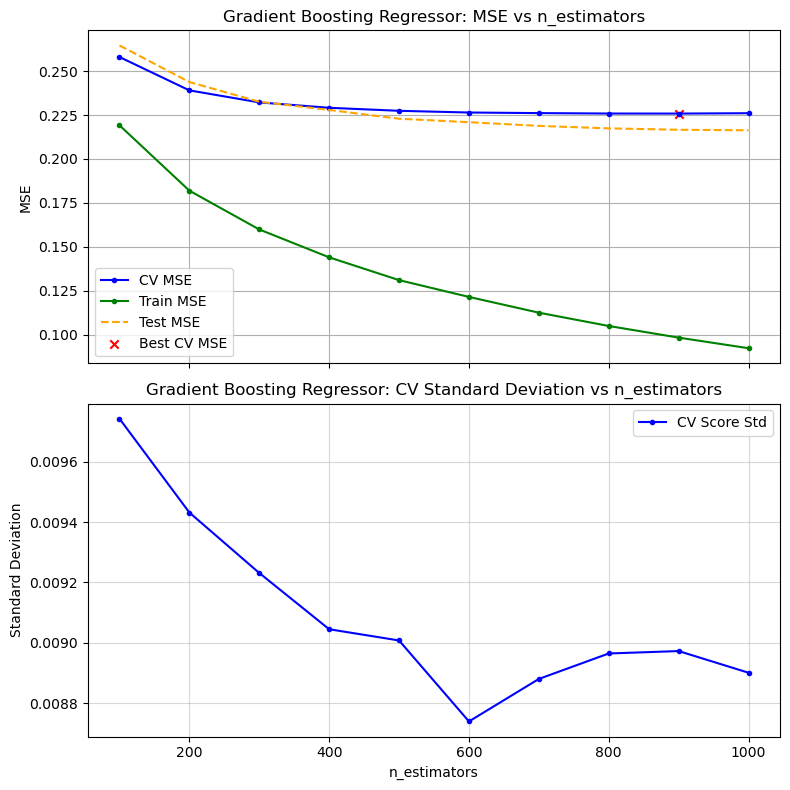

Minimum CV MSE 0.2258 found at n_estimators = 900
Learning Rate: 0.2
Execution Time: 00:08:34


In [7]:
# 1: Sweep n_estimators

sweep_parameter('n_estimators',range(100,1001,100))

Sweeping max_depth: 100%|█████████████████████████████████████████| 12/12 [49:28<00:00, 247.40s/it]


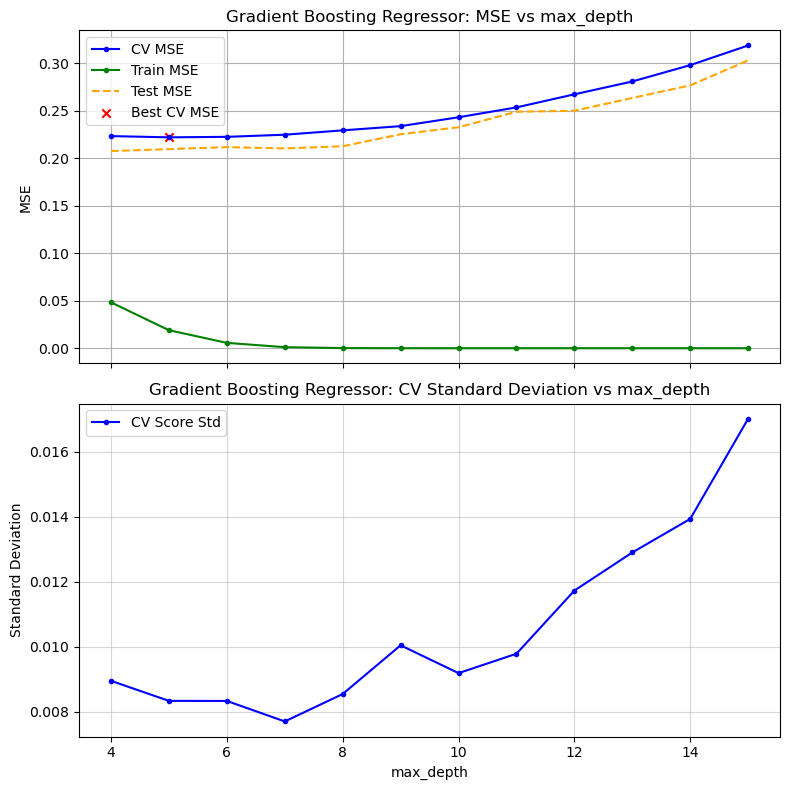

Minimum CV MSE 0.2219 found at max_depth = 5
Learning Rate: 0.2
Execution Time: 00:49:28


In [8]:
# 2: Sweep max_depth

sweep_parameter('max_depth', range(4,16))      

Sweeping max_features: 100%|█████████████████████████████████████████| 6/6 [08:26<00:00, 84.46s/it]


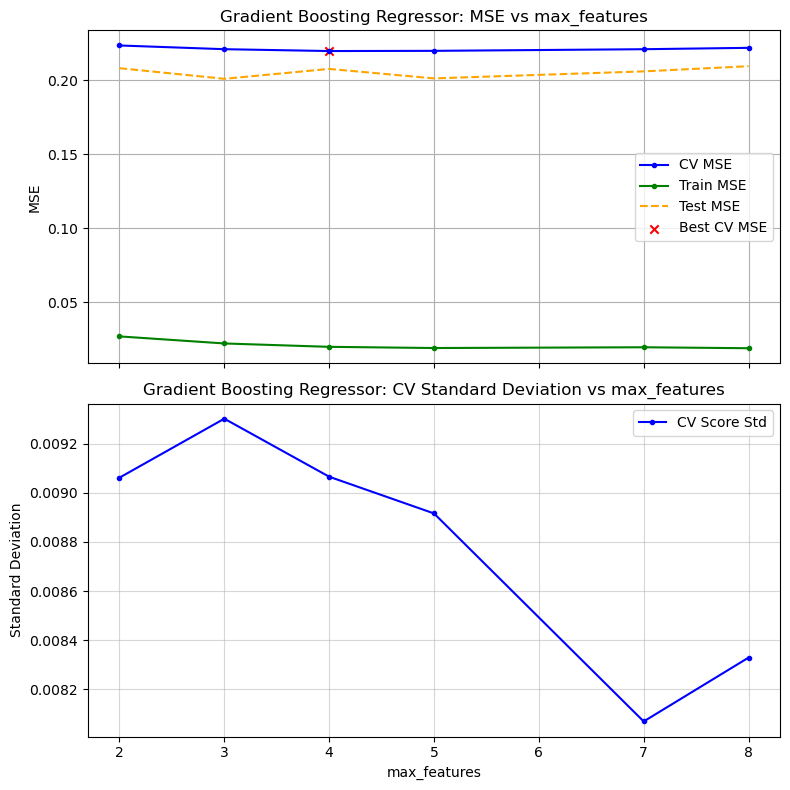

Minimum CV MSE 0.2197 found at max_features = 4
Learning Rate: 0.2
Execution Time: 00:08:26


In [9]:
# 3: Sweep max_features

sweep_parameter('max_features', [2,3,4,5,7,8])

Sweeping min_samples_split: 100%|████████████████████████████████████| 4/4 [04:43<00:00, 70.76s/it]


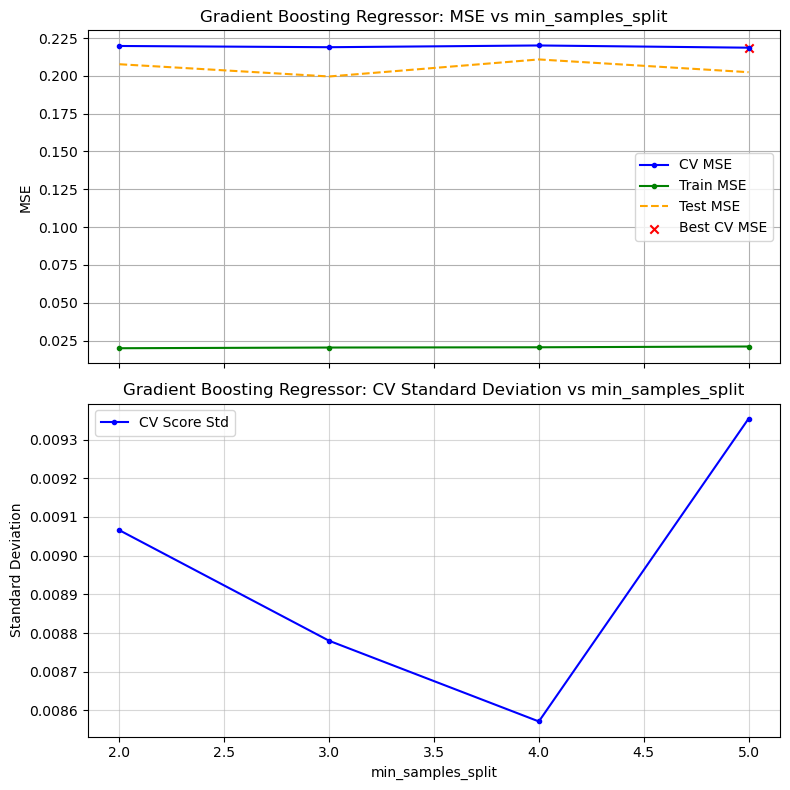

Minimum CV MSE 0.2186 found at min_samples_split = 5
Learning Rate: 0.2
Execution Time: 00:04:43


In [10]:
# 4: Sweep min_samples_split

sweep_parameter('min_samples_split', [2,3,4,5])

Sweeping min_samples_leaf: 100%|█████████████████████████████████████| 4/4 [04:42<00:00, 70.64s/it]


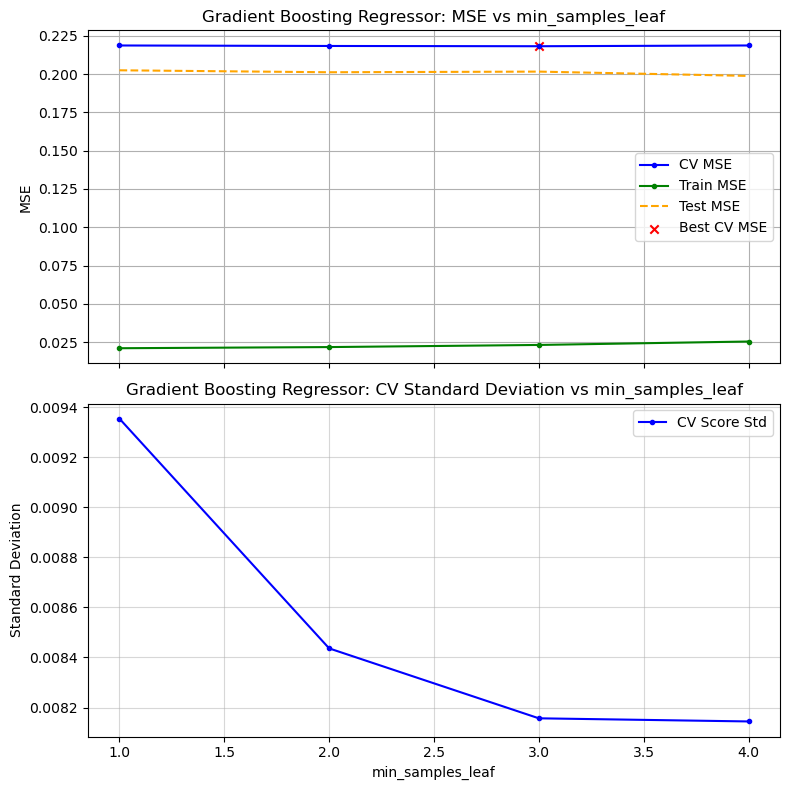

Minimum CV MSE 0.2181 found at min_samples_leaf = 3
Learning Rate: 0.2
Execution Time: 00:04:42


In [11]:
# 5: Sweep min_samples_leaf

sweep_parameter('min_samples_leaf', [1,2,3,4])

In [12]:
Parameters_List.append(Parameters.copy())

In [13]:
Parameters_List

[{'learning_rate': 0.2,
  'n_estimators': 900,
  'max_depth': 5,
  'min_samples_split': 5,
  'min_samples_leaf': 3,
  'max_features': 4,
  'max_leaf_nodes': None,
  'random_state': 42,
  'MSE_found': np.float64(0.21812919948813916)},
 {'learning_rate': 0.2,
  'n_estimators': 900,
  'max_depth': 5,
  'min_samples_split': 5,
  'min_samples_leaf': 3,
  'max_features': 4,
  'max_leaf_nodes': None,
  'random_state': 42,
  'MSE_found': np.float64(0.21812919948813916)}]

### Your Turn!  Try repeating the experiment with a different learning rate. 

- Try the above with a learning rate of 0.1 or even 0.01 (warning: it will take a long time, and you'll have to extend the range of n_estimators and you might want to set `n_repeats` in `RepeatedKFold` to 5 or even smaller).
- Can you find a better minimal CV MSE without signs of overfitting?
- What is the tradeoff between efficiency (how long it takes to find the best model) and the best MSE?

## Model Selection:  When is a model overfitting? What model to choose?

- **Minimize Mean CV MSE:** Aim for the model configuration with the lowest mean CV MSE as a primary indicator of good generalization.
- **Stable CV Performance:** Choose a model where the mean CV MSE plateaus—indicating additional improvements are marginal—rather than a continuously decreasing trend that may signal overfitting.
- **Gap Analysis:** Watch for an increasing gap between the mean CV MSE and testing MSE. A growing gap can be a sign of overfitting to the training data.
- **CV Score Consistency:** Favor models with a lower standard deviation in CV scores, as this reflects more consistent performance across different data splits.

## Two more tools for the toolbox: Early Stopping and Randomized Grid Search

### Early Stopping

Early stopping is a commonly-used technique for identifying an optimal model that balances underfitting and overfitting by halting training once the CV score ceases to improve. After exploring your parameter space through experiments and performance plots, early stopping can significantly speed up training across different parameter settings.

The built-in early stopping in `GradientBoostingRegressor` uses a single validation set, which, as we have discussed in Week 4,  may not provide a robust generalization estimate. To overcome this, a custom early stopping mechanism has been integrated into the `sweep_parameter` function. This mechanism monitors the mean CV score across 5 folds 10 iterations and stops training when further improvements are negligible. It is governed by two key parameters:

- **`delta`**: The minimum improvement threshold (default = 0.001). For an iteration to count as an improvement, the CV score must drop by at least this amount.
- **`n_iter_no_change`**: The number of consecutive iterations without sufficient improvement before halting the training process.

In an ideal scenario, the CV score decreases until it hits a minimum and then starts to increase. Depending on the value of `delta`, the stopping point might occur slightly before the absolute minimum, but the mechanism ensures that training never extends more than `n_iter_no_change` iterations past the optimal point. Also, note that the step size in your parameter sweep determines the magnitude of each change, which is critical for the stopping criterion.

This custom approach leverages cross-validation for a more robust stopping criterion, leading to better generalization and more efficient hyperparameter tuning.

In [14]:
sweep_parameter('n_estimators',range(100,1001,10),n_iter_no_change=5)

Sweeping n_estimators:  26%|██████████▎                            | 24/91 [07:15<20:15, 18.14s/it]

Early stopping: No improvement after 5 iterations.
No improvement found to best results so far.
Learning Rate: 0.2
Execution Time: 00:07:15


### Using Random Grid Search

`RandomizedSearchCV` is set up almost exactly the same as `GridSearchCV` but it will explore the search space of possible choices by choosing one value from each of the parameter ranges/distributions you specify. 
You can set the number of choices tried using `n_iter`. 

### Your Turn!

Run this next cell, first with n_iterations at 10 to see how it works, then with 100 or even 1000 (go watch a movie while it runs, or set your machine so that it doesn't go to sleep, and run it all night). 

If this is taking too long, you can try setting `n_repeats` to 5 or even smaller in the `RepeatedKFold` function. 

In [16]:
n_iterations = 10            # How many samples to take from the distributions shown here (rest are defaults):  

param_distributions = {
    'learning_rate'     : uniform(0.01, 0.3),
    'n_estimators'      : randint(100, 2000),
    'max_depth'         : randint(2, 16),
    'max_features'      : randint(2,9),
    'min_samples_split' : randint(2,6),
    'min_samples_leaf'  : randint(1,5),
}

# Initialize the GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=42)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator           = gbr,
    param_distributions = param_distributions,
    n_iter              = n_iterations,                                                       
    cv                  = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42),        
    random_state        = 42,
    n_jobs              = -1,        
    verbose             = 1
)

# Fit the model
random_search.fit(X_train, y_train)

# Convert the CV results to a DataFrame
results_df = pd.DataFrame(random_search.cv_results_)

# Sort by mean test score (higher is better for negative MSE) and select the top 10
top10 = results_df.sort_values(by="mean_test_score", ascending=False).head(10)

# Print out the 10 best models with their parameters and scores
print("Top 10 models:")
print(top10[["params", "mean_test_score", "std_test_score"]])

# Output the best parameters and scores
print("Best parameters:",             random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)
print("Test set score:",              random_search.score(X_test, y_test))


## Appendix 1: Comment on Parameters to Experiment With
1. Most useful parameters – `learning_rate`, `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`, and `max_features` are critical for balancing model complexity and preventing overfitting. `subsample` is most useful for very large datasets.
2. Moderately useful parameters – `loss` and `criterion` are secondary for initial experiments and may provide marginal improvements depending on the problem.
3. Less useful parameters – Features like `min_impurity_decrease`, `min_weight_fraction_leaf`, and `max_leaf_nodes` may be useful but are not typically the first things you would tune.
4. Least useful parameters – `ccp_alpha`, `init`, `verbose`, and `warm_start` are advanced options that are generally only useful in special cases. Pruning (`ccp_alpha`) is not very effective in boosting because each tree is already regularized through depth constraints, learning rate, and subsampling.

As usual, set `random_state=42` for all experiments to ensure reproducibility.

## Appendix 2: Key Parameter Trade-offs in Gradient Boosting
1. Learning Rate (`learning_rate`) vs. Number of Trees (`n_estimators`)  
   - Lower `learning_rate` → More trees needed (`n_estimators` ↑) to maintain performance.  
   - Try `learning_rate=0.01, n_estimators=500+` or `learning_rate=0.1, n_estimators=100-500`.

2. Tree Depth (`max_depth`) vs. Number of Trees (`n_estimators`)  
   - Shallower trees (`max_depth` ↓) need more boosting steps.  
   - For small datasets: `max_depth=5, n_estimators=200`. For large datasets: `max_depth=3, n_estimators=500+`.

3. Subsample (`subsample`) vs. Overfitting Risk  
   - Lowering `subsample` (e.g., 0.7) adds randomness, improving generalization.  
   - Only useful for large datasets; default (`subsample=1.0`) is fine otherwise.

4. Feature Sampling (`max_features`) vs. Model Stability  
   - Lower `max_features` adds randomness, reducing overfitting but slowing learning.  
   - Try `max_features='sqrt'` for large datasets or `max_features=0.8` for stable results.

5. Minimum Samples (`min_samples_split` / `min_samples_leaf`) vs. Tree Complexity  
   - Increasing these makes trees simpler, reducing overfitting but missing fine details.  
   - If trees overfit, try `min_samples_leaf=5-10`.


### Results from previous experiments

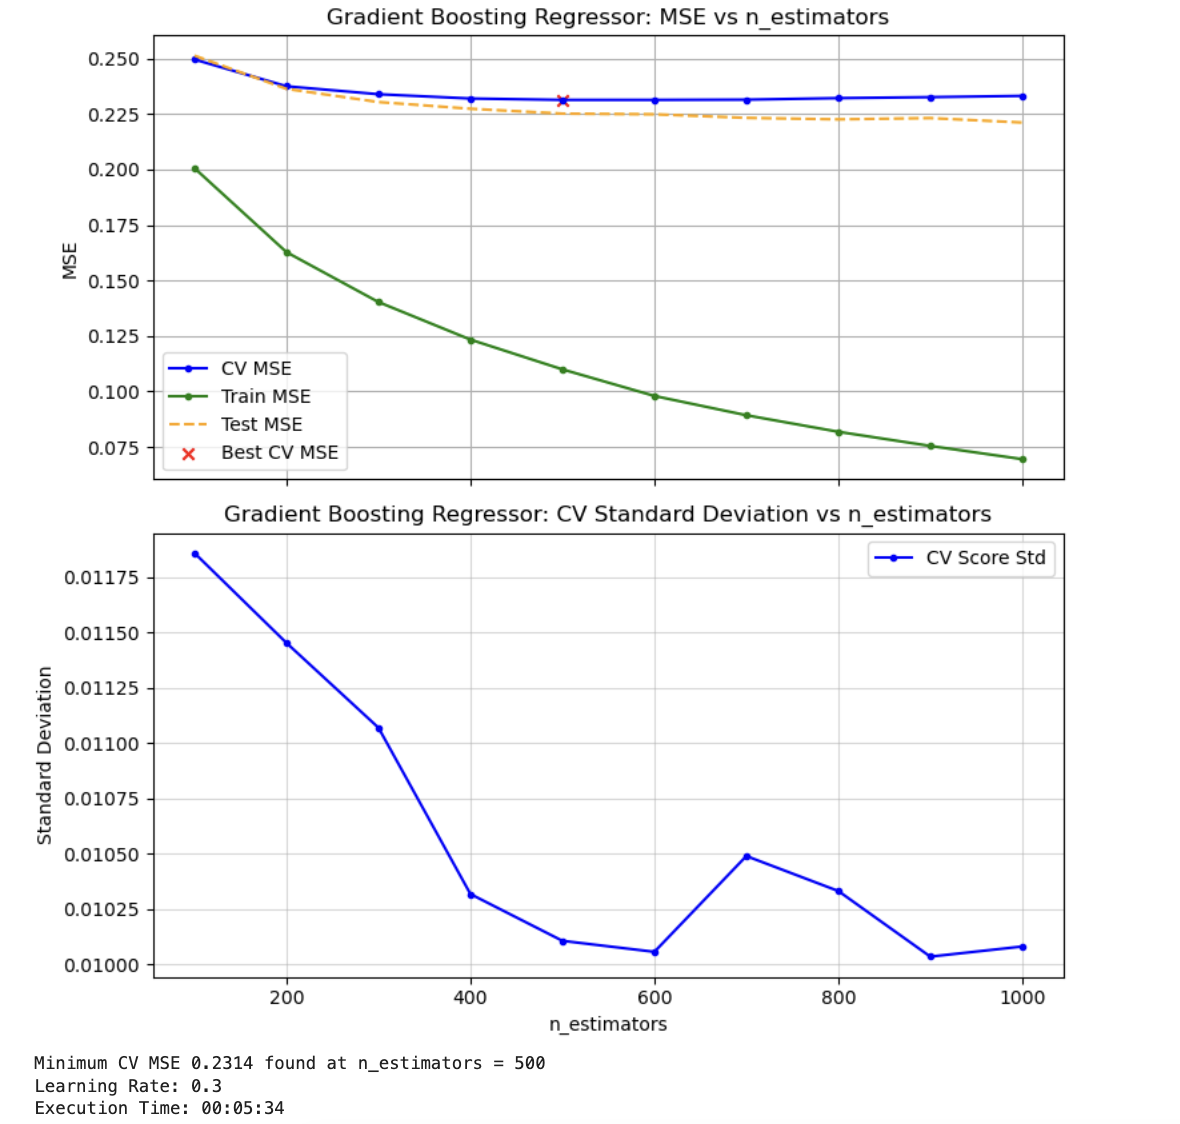